# Grad-CAM
[Grad-CAM]的TensorFlow 2.X实现(https://arxiv.org/pdf/1610.02391.pdf)，一种用于模型可解释性的方法，该方法生成热图，图像的哪些区域对最终预测有很大贡献。

In [2]:
%matplotlib inline

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import imageio.v3 as iio
from tensorflow.keras.preprocessing.image import load_img
import cv2
import os
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

Grad CAM输出是一个激活图，将检测到的对象定位到图像中的某个区域。对于类$c$，它的宽度为$u$，高度为$v$。
$$
L^{c}_{\textrm{Grad-CAM}} \in \mathbb{R}^{u \times v}
$$

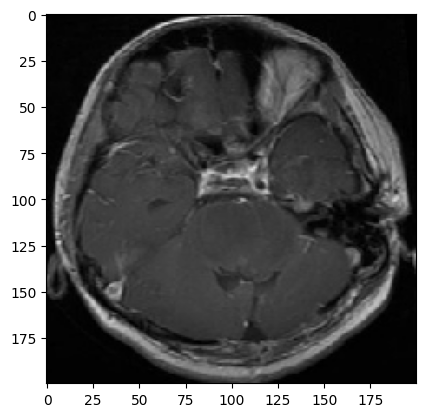

In [8]:
image = np.array(load_img(r"E:\source_code\Multiclass_Brain_tumour_Classification_using_Resnet-50-main\Dataset\cropped\Testing\glioma\Te-gl_0010.jpg", target_size=(200, 200, 3)))
plt.imshow(image)

In [9]:
model = load_model('bestresnet.h5')

我们得到最后一个卷积层的输出。然后，我们创建一个仅向上到该层的模型。

In [10]:
last_conv_layer = model.get_layer("conv5_block3_out")
last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

In [26]:
# model.summary()

我们创建一个模型，然后获取上述模型的输出，并使用剩余的层来获得最终的预测。

In [12]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["global_average_pooling2d"]:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

首先，我们得到模型直到最后一个卷积层的输出。
我们要求“tf”观察这个张量输出，因为我们想计算目标类wrt的预测到这个模型（最后一个卷积层模型）输出的梯度。

In [13]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

模型输出的偏导数/梯度（logits/softmax之前）$y^{c}$相对于指定卷积层（本例中为最后一个卷积层）的特征图（滤波器）激活为：
$$
\frac{\partial y^{c}}{\partial A^{k}_{ij}}
$$

In [14]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

梯度的形状为“（u，v，Z）”，其中“（u、v）”来自2D卷积滤波器的形状（即宽度和高度），“Z”是滤波器的数量。下一步将每个过滤器平均为一个值，这样最终的形状就是“Z”或过滤器的数量。这相当于全局平均池化2D层。

$$
\alpha_{k}^{c}=\frac{1}{Z}\sum_{i}\sum_{j}\frac{\partial y^{c}}{\partial A^{k}_{ij}}
$$

这些梯度中的每一个都表示从2D阵列中的一个像素到表示目标类的神经元/输出的连接。

In [16]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

这就是模型中的下一层所做的，这是一个全局平均池化2D层，它将$u\times v$形状的$z$个过滤器平均并平坦化为单个数字（正是我们在上一步所做的）。这对于为最终预测输出创建与完全连接（密集）层的连接是必要的。

下一步是将梯度（对应于给定特征图/过滤器的重要性）与其表示的实际特征图（过滤器）相乘。

$$
ReLU\bigg(\sum_{k} a^{c}_{k}A^{k}\bigg)
$$

In [17]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [18]:
gradcam = np.mean(last_conv_layer_output, axis=-1)
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (200, 200))

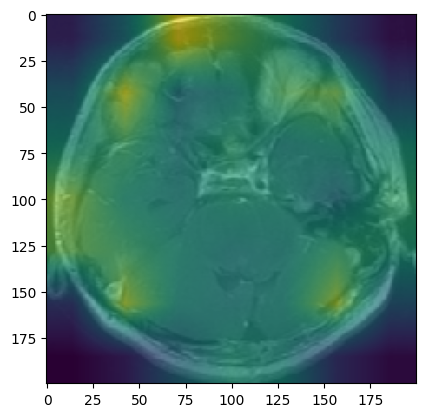

In [19]:
plt.imshow(image)
plt.imshow(gradcam, alpha=0.6)

In [31]:
image = np.array(load_img(r"E:\source_code\Multiclass_Brain_tumour_Classification_using_Resnet-50-main\Dataset\cropped\Testing\glioma\Te-gl_0010.jpg", target_size=(200, 200, 3)))



conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
heatmap_paths = []

for last_conv_layer in conv_layers:
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in ["global_average_pooling2d"]:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        inputs = image[np.newaxis, ...]
        last_conv_layer_output = last_conv_layer_model(inputs)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    gradcam = np.mean(last_conv_layer_output, axis=-1)
    gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
    gradcam = cv2.resize(gradcam, (200, 200))
    # print('==============')

    # 将热力图叠加在原始图像上
    heatmap = np.uint8(255 * gradcam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.6 + img
    
    # 保存热力图
    heatmap_path = f'./result/layer_{last_conv_layer.name}_heatmap.png'
    cv2.imwrite(heatmap_path, superimposed_img)
    heatmap_paths.append(heatmap_path)

    # plt.imshow(image)
    # plt.imshow(gradcam, alpha=0.6)



AttributeError: 'PillowPlugin' object has no attribute 'append_data'

In [32]:
import imageio


images = []

for path in heatmap_paths:
    images.append(imageio.imread(path))
imageio.mimsave('./over/layer_heatmaps.gif', images)

# 清理临时文件
for path in heatmap_paths:
    os.remove(path)

# Counterfactual explanation

通过否定 $\frac{\partial y^{c}}{\partial A^{k}}$ 的值，我们可以生成一个区域图，这将降低网络对其预测的信心。当图像中存在两个相互竞争的对象时，这很有用。我们可以生成一个掩盖了这些区域的“反事实”图像，这应该会给原始预测带来更高的置信度。

In [23]:
multiobject_image = np.array(
    load_img("Te-gl_0010.jpg", target_size=(200, 200, 3))
)

In [24]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(multiobject_image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [25]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

取梯度的负值，以针对对加强网络预测没有贡献的区域。

In [26]:
pooled_grads = tf.reduce_mean(-1 * grads, axis=(0, 1, 2))

In [27]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [28]:
# Average over all the filters to get a single 2D array
ctfcl_gradcam = np.mean(last_conv_layer_output, axis=-1)
# Normalise the values
ctfcl_gradcam = np.clip(ctfcl_gradcam, 0, np.max(ctfcl_gradcam)) / np.max(ctfcl_gradcam)
ctfcl_gradcam = cv2.resize(ctfcl_gradcam, (200, 200))

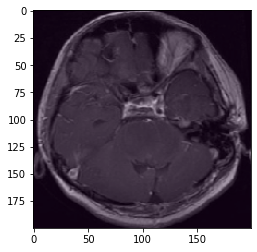

In [31]:
plt.imshow(multiobject_image)
plt.imshow(ctfcl_gradcam, alpha=0.3)

我们可以屏蔽反事实图所标识的区域，并重新运行预测，在那里我们应该看到输出的置信度更高。

In [32]:
mask = cv2.resize(ctfcl_gradcam, (200, 200))
mask[mask > 0.1] = 255
mask[mask != 255] = 0
mask = mask.astype(bool)

In [33]:
ctfctl_image = multiobject_image.copy()
ctfctl_image[mask] = (0, 0, 0)

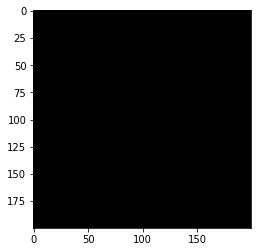

In [34]:
plt.imshow(ctfctl_image)

---

# Guided Grad-CAM

通过与引导反向传播相结合，可以进一步提高梯度CAM输出，引导反向传播将梯度中对决策产生负面影响的元素归零

In [30]:
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [31]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
last_conv_layer_output = last_conv_layer_output[0]

Guided backpropagation implementation:

In [32]:
guided_grads = (
    tf.cast(last_conv_layer_output > 0, "float32")
    * tf.cast(grads > 0, "float32")
    * grads
)

In [33]:
pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

In [34]:
for i, w in enumerate(pooled_guided_grads):
    guided_gradcam += w * last_conv_layer_output[:, :, i]

In [35]:
guided_gradcam = cv2.resize(guided_gradcam.numpy(), (200, 200))

In [36]:
guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
    guided_gradcam.max() - guided_gradcam.min()
)

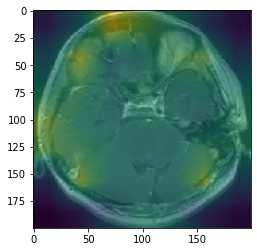

In [37]:
plt.imshow(image)
plt.imshow(guided_gradcam, alpha=0.5)

---

# Guided Grad-CAM (high resolution maps)
这种方法更好地反映了论文的描述，首先使用引导反向传播方法生成与输入图像分辨率相同的高分辨率图，然后使用Grad-CAM热图对其进行掩盖，只关注导致预测结果的细节。

In [38]:
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

    return tf.nn.relu(x), grad

In [39]:
class GuidedBackprop:
    def __init__(self, model, layer_name: str):
        self.model = model
        self.layer_name = layer_name
        self.gb_model = self.build_guided_model()

    def build_guided_model(self):
        gb_model = tf.keras.Model(
            self.model.inputs, self.model.get_layer(self.layer_name).output
        )
        layers = [
            layer for layer in gb_model.layers[1:] if hasattr(layer, "activation")
        ]
        for layer in layers:
            if layer.activation == tf.keras.activations.relu:
                layer.activation = guided_relu
        return gb_model

    def guided_backprop(self, image: np.ndarray):
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            outputs = self.gb_model(inputs)
        grads = tape.gradient(outputs, inputs)[0]
        return grads

In [40]:
gb = GuidedBackprop(model, "conv5_block3_out")

In [41]:
saliency_map = gb.guided_backprop(image[np.newaxis, ...]).numpy()
saliency_map = saliency_map * np.repeat(guided_gradcam[..., np.newaxis], 3, axis=2)

In [42]:
saliency_map -= saliency_map.mean()
saliency_map /= saliency_map.std() + tf.keras.backend.epsilon()
saliency_map *= 0.25
saliency_map += 0.5
saliency_map = np.clip(saliency_map, 0, 1)
saliency_map *= (2 ** 8) - 1
saliency_map = saliency_map.astype(np.uint8)

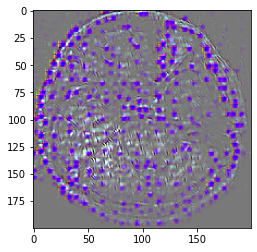

In [43]:
plt.imshow(saliency_map)